In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
tennis <- read_csv('player_stats.csv')
colnames(tennis) <- make.names(colnames(tennis))

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
tennis_data <- tennis |>
filter(Active == "Yes") |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Best.Rank, into = c("Best.Rank", "Best.Rank.Date"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
separate(col = Best.Elo.Rank, into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"), sep = " ") |>
separate(col = Peak.Elo.Rating, into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"), sep = " ") |>
mutate(Current.Rank = as.numeric(Current.Rank), Current.Elo.Rank = as.numeric(Current.Elo.Rank),
       Best.Elo.Rank = as.numeric(Best.Elo.Rank), Peak.Elo.Rating = as.numeric(Peak.Elo.Rating), Best.Rank = as.numeric(Best.Rank),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prev.Rank = as.numeric(gsub("[^0-9.-]", "", Prev.Rank)),
       Money.Per.Season = Prize.Money/Seasons, Age = as.numeric(Age)) |>
select(Name, Age, Seasons, Current.Rank, Prev.Rank, Best.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Elo.Rank, Peak.Elo.Rating,
           Prize.Money, Money.Per.Season) |>
filter(!is.na(Money.Per.Season), !is.na(Age), !is.na(Current.Rank), !is.na(Best.Rank), !is.na(Current.Elo.Rating), !is.na(Peak.Elo.Rating))
tennis_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Name,Age,Seasons,Current.Rank,Prev.Rank,Best.Rank,Current.Elo.Rank,Current.Elo.Rating,Best.Elo.Rank,Peak.Elo.Rating,Prize.Money,Money.Per.Season
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,14,178,280,44,144,1764,60,1886,3261567,232969.1
Bernard Tomic,27,11,183,273,17,100,1826,21,2037,6091971,553815.5
Hubert Hurkacz,22,5,31,1398,31,33,1983,33,1983,1517157,303431.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Brayden Schnur,24,4,103,534,92,186,1627,161,1733,414637,103659.25
Mirza Basic,28,7,292,138,74,143,1764,57,1904,1048314,149759.14
Dimitar Kuzmanov,26,8,324,120,249,180,1679,179,1679,132871,16608.88


In [24]:
set.seed(16)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

Below is a table organizing the players by number of active seasons, and giving the mean values for potential predicotr variables. Additionally, we included a table containing the amount of missing values for each predictor variable over our training set.

In [25]:
players_by_seasons <- tennis_training |>
    group_by(Seasons) |>
    summarize(count = n(), Mean.Best.Rank = mean(Best.Rank,na.rm = TRUE), Mean.Peak.Rating = mean(Peak.Elo.Rating,na.rm = TRUE),
              Mean.Current.Rank = mean(Current.Rank, na.rm = TRUE), Mean.Current.Rating = mean(Current.Elo.Rating, na.rm = TRUE))
missing_tennis_data <- tennis_training |>
    summarize(Active.Players = n(),
              Missing.Best.Rank = sum(is.na(Best.Rank)),
              Missing.Current.Rank = sum(is.na(Current.Rank)),
              Missing.Peak.Elo = sum(is.na(Peak.Elo.Rating)),
              Missing.Current.Elo = sum(is.na(Current.Elo.Rating)))
players_by_seasons
missing_tennis_data

Seasons,count,Mean.Best.Rank,Mean.Peak.Rating,Mean.Current.Rank,Mean.Current.Rating
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,80.00000,1772.000,85.0000,1763.000
3,12,86.58333,1830.083,100.0833,1806.917
4,8,85.12500,1831.625,111.1250,1789.125
⋮,⋮,⋮,⋮,⋮,⋮
18,1,18,2029,85,1879
19,1,1,2552,1,2406
20,1,14,2062,124,1806


Active.Players,Missing.Best.Rank,Missing.Current.Rank,Missing.Peak.Elo,Missing.Current.Elo
<int>,<int>,<int>,<int>,<int>
120,0,0,0,0


Below are some plots visualizing the relationships between potential predictor variables and Prize Money, or Prize Money per Season.
Due to being an extreme outlier in terms of Prize Money, for visualization purposes we have removed Rafael Nadal from the data set. We still plan to use him in our model.

In [26]:
tennis_data_for_viz <- tennis_training |>
    filter(Name != "Rafael Nadal")

$title
[1] "Seasons vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Seasons vs Money per Seasons"

attr(,"class")
[1] "labels"

$title
[1] "Age vs Money Per Season"

attr(,"class")
[1] "labels"

$title
[1] "Peak Elo Rating vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Best Rank vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Current Elo vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Current Elo Rating"

attr(,"class")
[1] "labels"

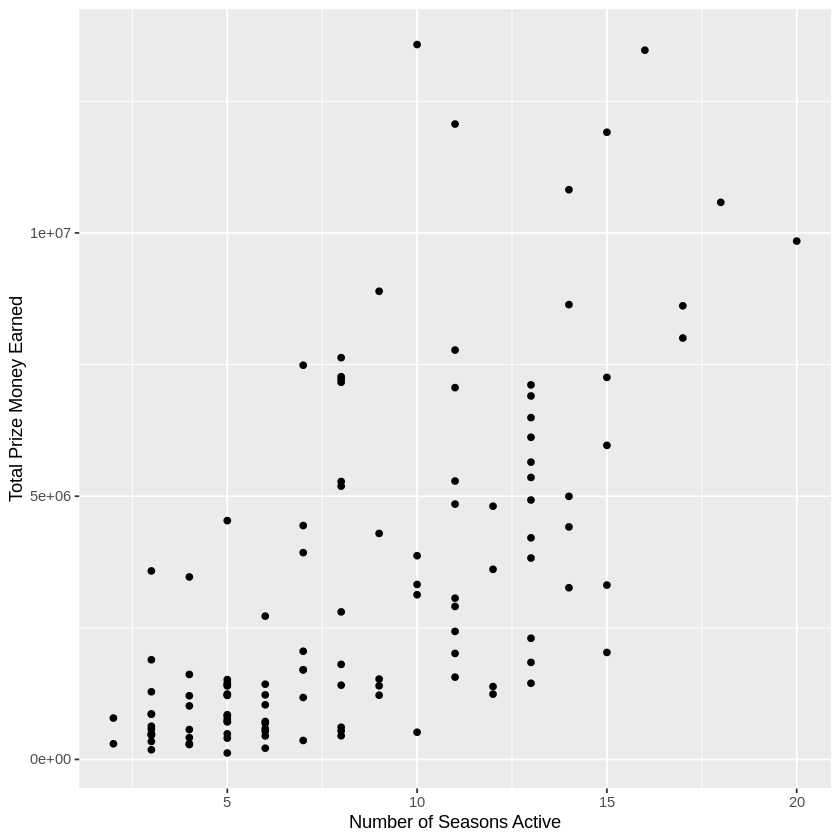

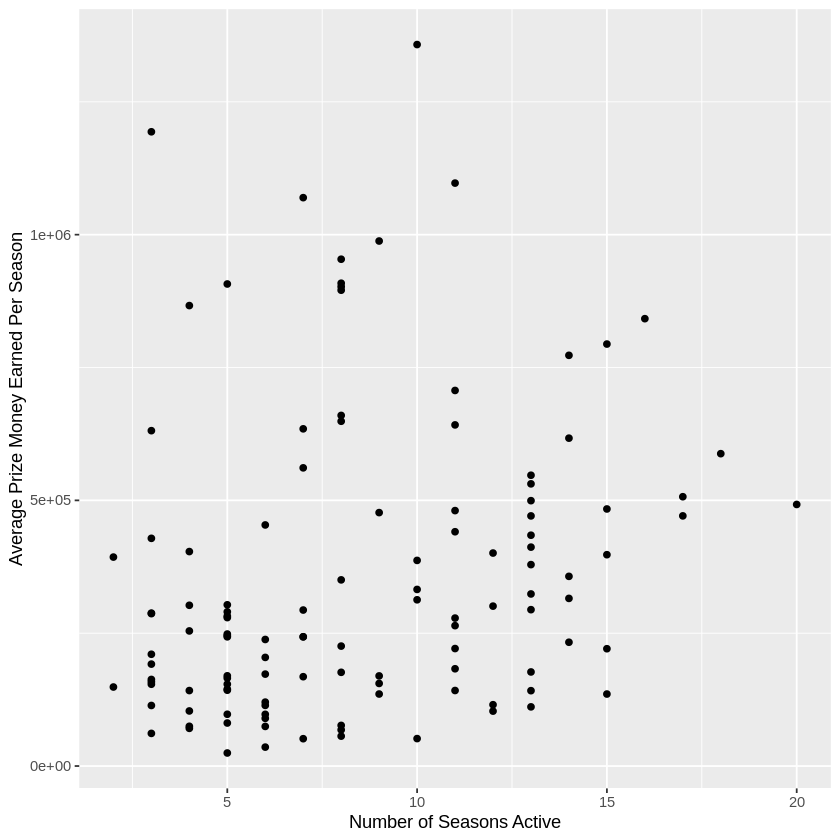

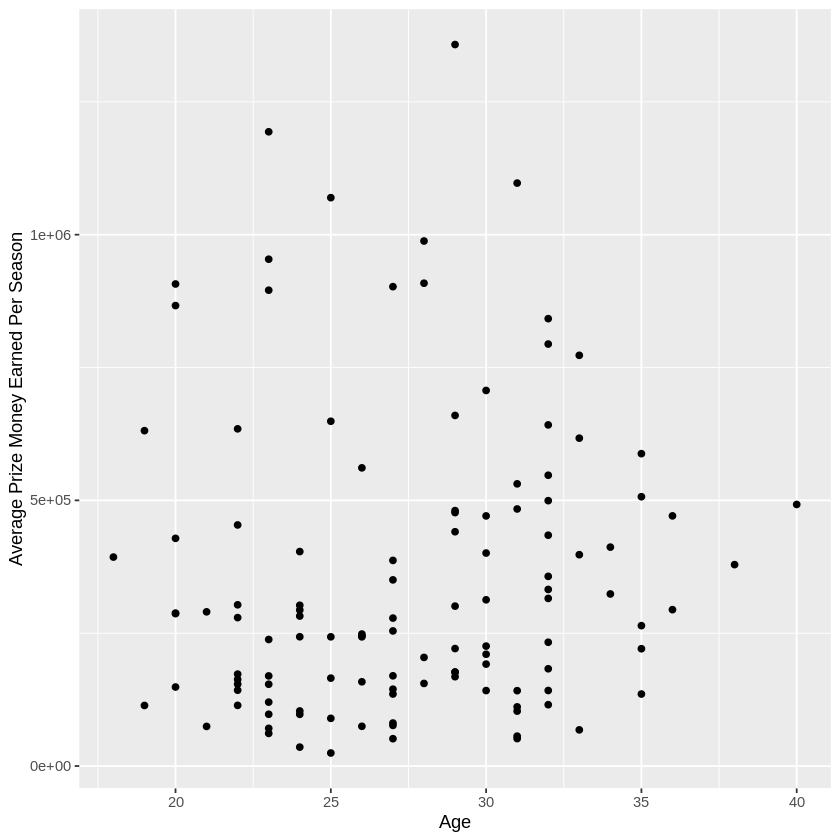

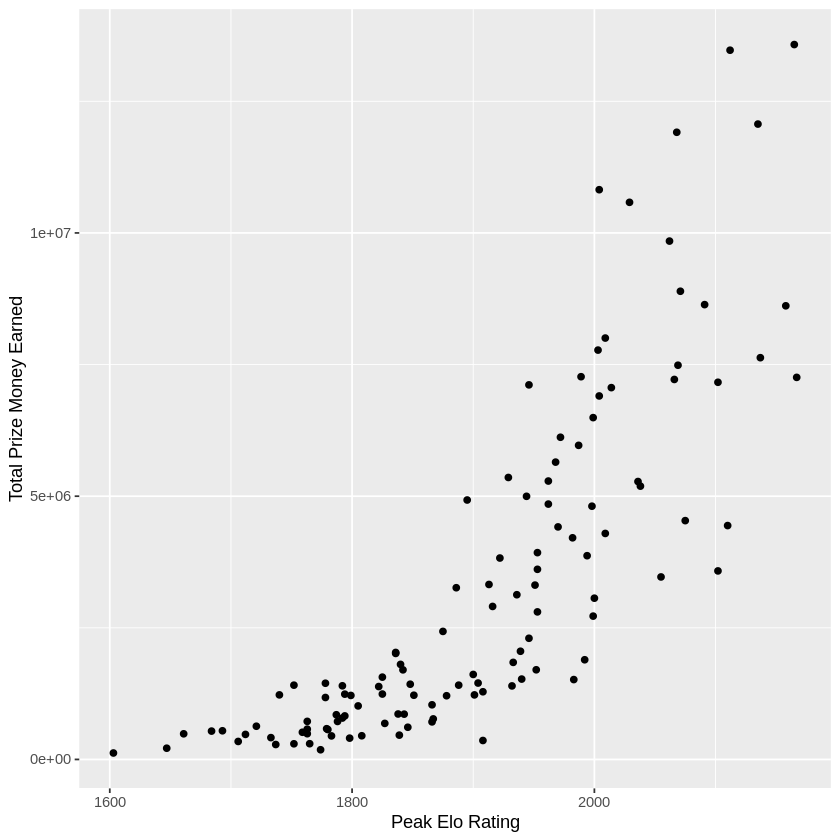

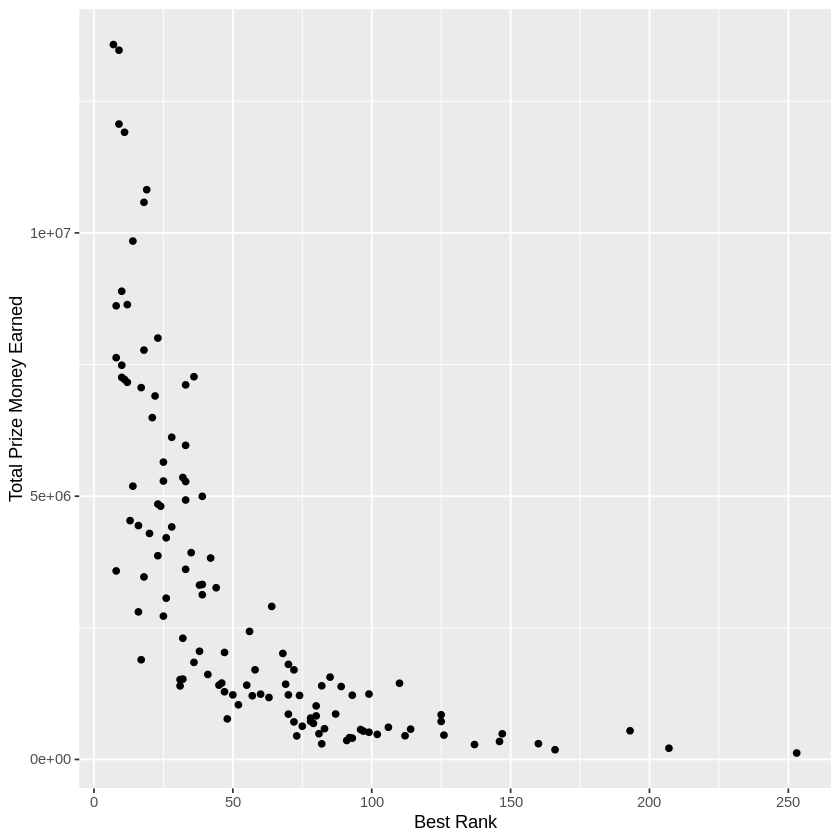

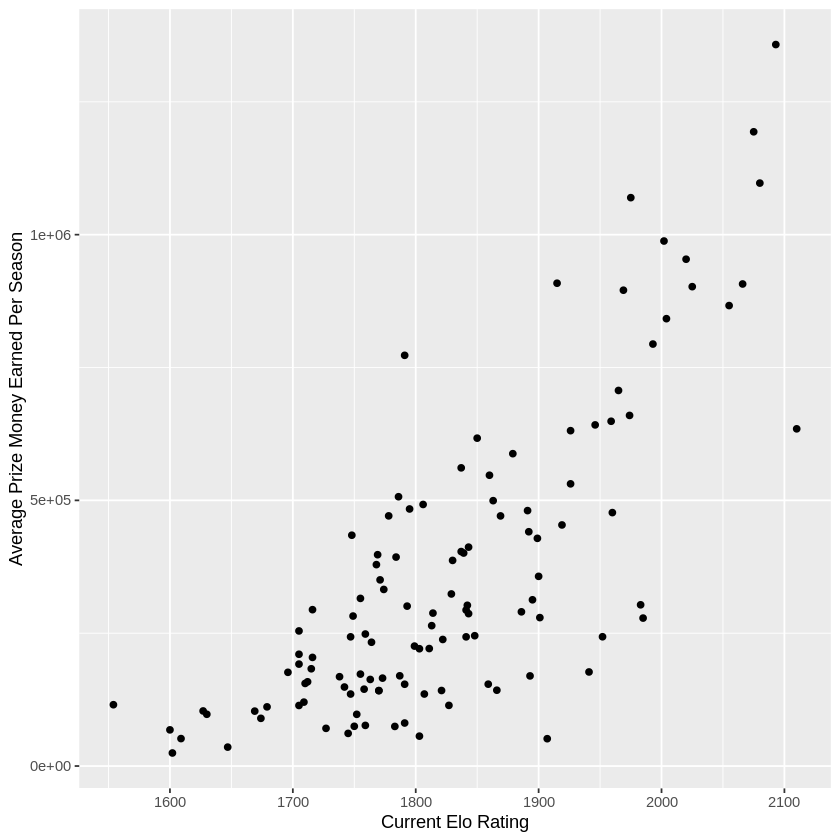

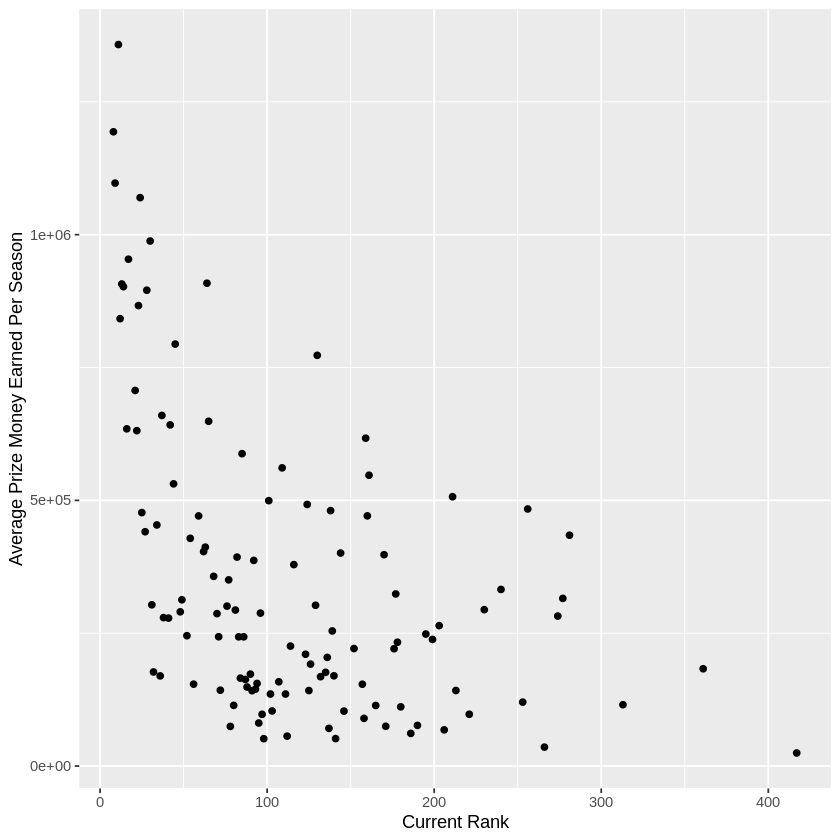

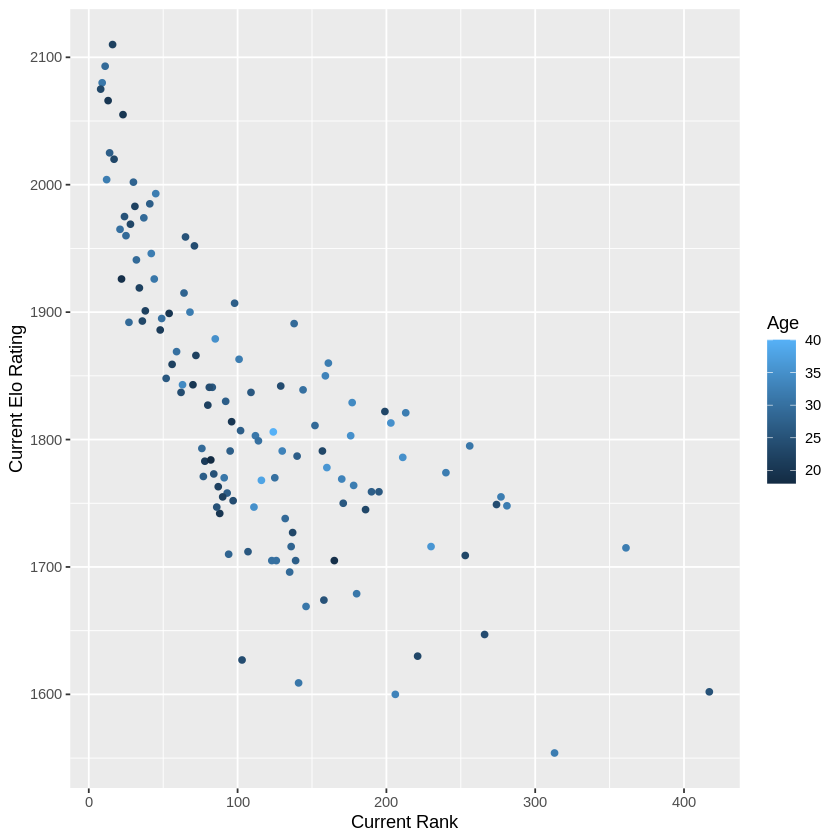

In [27]:
tennis_plot_seasons <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Prize.Money)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Total Prize Money Earned")
    ggtitle("Seasons vs Prize Money")
tennis_plot_money_per_season <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Average Prize Money Earned Per Season")
    ggtitle("Seasons vs Money per Seasons")
tennis_plot_age <- tennis_data_for_viz |>
    ggplot(aes(x = Age, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Age", y = "Average Prize Money Earned Per Season")
    ggtitle("Age vs Money Per Season")
tennis_plot_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Peak.Elo.Rating, y = Prize.Money)) +
    geom_point() +
    labs(x = "Peak Elo Rating", y  = "Total Prize Money Earned")
    ggtitle("Peak Elo Rating vs Prize Money")
tennis_plot_rank <- tennis_data_for_viz |>
    ggplot(aes(x = Best.Rank, y = Prize.Money)) +
    geom_point() +
    labs(x = "Best Rank", y = "Total Prize Money Earned")
    ggtitle("Best Rank vs Prize Money")
tennis_plot_elo_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Elo Rating", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Elo vs Money per Year")
tennis_plot_rank_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Rank", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Rank vs Money per Year")
tennis_plot_current_rank_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Current.Elo.Rating, color = Age)) +
    geom_point() +
    labs(x = "Current Rank", y = "Current Elo Rating")
    ggtitle("Current Rank vs Current Elo Rating")
tennis_plot_seasons
tennis_plot_money_per_season
tennis_plot_age
tennis_plot_elo
tennis_plot_rank
tennis_plot_elo_perYear
tennis_plot_rank_perYear
tennis_plot_current_rank_elo

Data_analysis

In [30]:
set.seed(16)
tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = Money.Per.Season)
ks <- tibble(neighbors = seq(1,15))

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

tennis_recipe <- recipe(Money.Per.Season ~ Age + Current.Rank + Current.Elo.Rating, data = tennis_training)

tennis_workflow <- workflow() |>
    add_model(tennis_spec) |>
    add_recipe(tennis_recipe)

In [31]:
tennis_results <- tennis_workflow |>
    tune_grid(resamples = tennis_vfold, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min <- tennis_results |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_results
k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,426319.1,5,162678.0,Preprocessor1_Model01
2,rmse,standard,379683.5,5,178159.0,Preprocessor1_Model02
3,rmse,standard,371067.0,5,184937.1,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,rmse,standard,367548.1,5,194123.0,Preprocessor1_Model13
14,rmse,standard,369653.9,5,194549.5,Preprocessor1_Model14
15,rmse,standard,370343.9,5,194720.0,Preprocessor1_Model15


[1] 4